In [4]:
import pandas as pd
import numpy as np
import torch
from data_reader import read_interaction_matrix
R = read_interaction_matrix()
from tqdm import tqdm

n_users, n_items = R.shape
n_latent = 64
r = 0.001

# learning rate
INIT_LR = 0.05
END_LR = 0.0001
n_epochs = 750

# error check steps
erc_step = 100
# min error threshold
eth = 1e-4

rng = np.random.default_rng(seed=1234)
scale = 1./n_latent
Q0 = rng.normal(scale=scale, size=(n_users, n_latent))
P0 = rng.normal(scale=scale, size=(n_items, n_latent))

def E(R, P, Q):
    return np.abs(R - Q@P.T).sum() + r*((Q*Q).sum() + (P*P).sum())

def LR(epoch, warmup):
    s = warmup / n_epochs
    x = (epoch - n_epochs)/n_epochs
    
    if epoch >= warmup:
        x = x - s
        y = ((1 + x))
        
        # y = (n_epochs*(s-1) + 1/(1 - s))*x + n_epochs*(1-s)
        # y = y * n_epochs / (n_epochs - s*n_epochs)
    else:
        x += 1
        y = (-2./s)*(x**2) + 2*s
        
    # f = lambda e : ((e/n_epochs)) * (((e/5 + (1-stop_warmup)*n_epochs)/n_epochs)**5)
    # y = f(2/3*n_epochs + (-n_epochs + epoch)*3.)
    # if epoch < stop_warmup:
    #     x *= ((-epoch + stop_warmup//2)*3/n_epochs)**3
    #     if epoch % 20 == 0:
    #         print("warmup")
    # z = lambda x : (x - 1/3)**(0.3) * np.exp(-x**(0.8))
    
    lr = INIT_LR - (INIT_LR-END_LR) * y
    return lr


5it [00:00, 20.20it/s]

err: 2.29e+04, lr: 0.0024500, last batch: None


365it [00:06, 96.70it/s]

err: 1.16e+04, lr: 0.0147665, last batch: 64


710it [00:11, 85.75it/s] 

err: 9.26e+03, lr: 0.0105250, last batch: 16


1062it [00:15, 98.25it/s] 

err: 8.41e+03, lr: 0.0075446, last batch: 16


1415it [00:19, 94.04it/s] 

err: 8.20e+03, lr: 0.0054502, last batch: 16


1755it [00:24, 60.54it/s]

err: 4.84e+03, lr: 0.0039785, last batch: 4


2106it [00:30, 49.92it/s]

err: 4.11e+03, lr: 0.0029444, last batch: 4


2458it [00:36, 71.51it/s]

err: 3.68e+03, lr: 0.0022176, last batch: 1


2805it [00:42, 53.36it/s]

err: 3.25e+03, lr: 0.0017070, last batch: 1


3158it [00:46, 71.08it/s]

err: 2.95e+03, lr: 0.0013406, last batch: 1


3501it [00:51, 70.53it/s]

err: 2.76e+03, lr: 0.0009981, last batch: 1


3855it [00:57, 65.12it/s]

err: 2.63e+03, lr: 0.0006556, last batch: 1


4010it [01:00, 66.77it/s]

best error: 2.59e+03


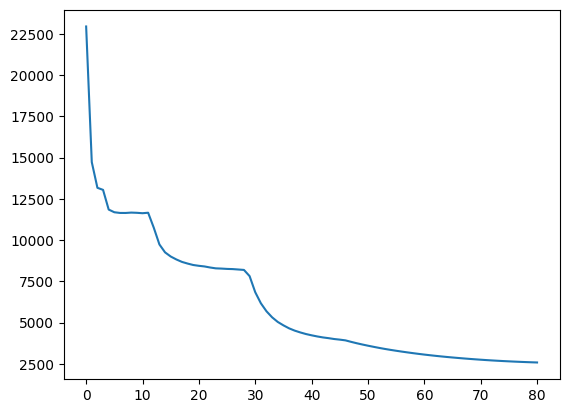

In [1]:
from data_reader import read_interaction_matrix
R = read_interaction_matrix()

from mf import matrix_factorization
from matplotlib import pyplot as plt

def get_errors(logs):
    errors = [log[0] for log in logs]
    return errors

q, p, err, logs = matrix_factorization(
    R, lr=(2e-2, 2e-3), n_epochs=3010, ff=0.05, reg=0.001, n_latent=64, log_step=50, print_step=350,
    sample_s=0.005, batch_sample_s=0.05
    )
errors = get_errors(logs)

print(f'best error: {err:.2e}')
plt.plot(errors)

In [2]:
import numpy as np
S = (q @ p.T)
S.sum(), R.sum(), S[R.nonzero()]

(185356.37639551942,
 23038.0,
 array([1.03055607, 0.91485724, 1.10436426, ..., 0.88592223, 0.9158253 ,
        0.94324758]))

In [3]:
s = (q@p.T)

def frmt(f):
    i = 5
    i += 1 if f < 0 else 0
    return str(f)[:i]

def describe(M, name=None):
    print((f'{name}\t' if name else '') + f'mean: {frmt(M.mean())}, min: {frmt(M.min())}, max: {frmt(M.max())}')

describe(R, 'R stat')
describe(S, 'S stat')
describe(S[R.nonzero()], 'Positives stat')
describe((S - S*R), 'Others stat')

R stat	mean: 0.023, min: 0.0, max: 1.0
S stat	mean: 0.188, min: -0.935, max: 1.491
Positives stat	mean: 0.979, min: 0.330, max: 1.491
Others stat	mean: 0.165, min: -0.935, max: 1.444


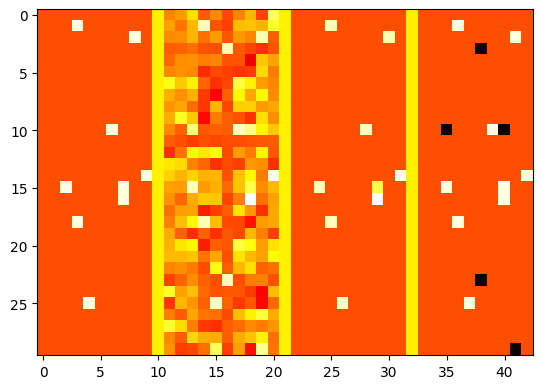

In [4]:
from mf import heatmap
import numpy as np

S = q @ p.T

FP = np.zeros_like(S)
FP[S > S.max() * 0.5] = -1
FP[R.nonzero()] = 1

P = S * R
Z = S - (S * R)

D = np.zeros((P.shape[0], 1))
D[:,0] = 0.5

t = tuple(M[60:90, 0:10] for M in (R, D, S, D, P, D, FP))
V = np.concatenate(t, axis=1)
heatmap(V)